In [1]:
import ray

In [2]:
# Initialize ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-12 11:53:37,698	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.11.4
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8266


In [3]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'node:192.168.1.124': 1.0,
 'CPU': 4.0,
 'object_store_memory': 992671334.0,
 'memory': 1985342670.0}

In [4]:
num_workers = 3
resources_per_worker={"CPU": 1, "GPU": 0}

## Data Preparation
preparing the dataset by ingesting and splitting it.

### Ingestion
Loading from a CSV file to a Pandas Dataframe

In [5]:
import pandas as pd

In [6]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


### Splitting


<details>
    <summary>Split data into train, and validation sets.</summary>
    While we could have one large dataset and split that into the three splits, it's a good idea to have a separate test dataset. Over time, our training data may grow and our test splits will look different every time. This will make it difficult to compare models against other models and against each other.
</details>


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

For our multi-class task (where each project has exactly one tag), we want to ensure that the data splits have similar class distributions. We can achieve this by specifying how to stratify the split by using the stratify keyword argument with sklearn's train_test_split() function.


<details>
    <summary>criteria we should focus on to ensure proper data splits:</summary>
    - the dataset (and each data split) should be representative of data we will encounter
    - equal distributions of output values across all splits
    - shuffle your data if it's organized in a way that prevents input variance
    - avoid random shuffles if your task can suffer from data leaks (ex. time-series)
</details>



In [9]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

<details>
    <summary>How can we validate that our data splits have similar class distributions?</summary>
    We can view the frequency of each class in each split:
</details>


In [10]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

<details>
    <summary>Before we view our validation split's class counts</summary>
     recall that our validation split is only test_size of the entire dataset. So we need to adjust the value counts so that we can compare it to the training split's class counts.
$$
    \alpha = \frac{N_{train}}{N_{test}} = \frac{1 - N_{test}}{N_{test}}
$$
</details>

In [11]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [12]:
# Validation (adjusted) vaaaaaaluee counts
val_df.tag.value_counts()*int((1-test_size)/test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)
exploring the dataset for insights, with intention

<details>
    <summary>Here's how to think about EDA:</summary>
> not just to visualize a prescribed set of plots (correlation matrix, etc.).
- goal is to convince yourself that the data you have is sufficient for the task.
- use EDA to answer important questions and to make it easier to extract insight
- not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc.
</details>

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

### Tag ditribution

<details>
    <summary>How many data points do we have per tag?</summary>
We'll use the Counter class to get counts for all the different tags.
</details>

In [14]:
# Most commin tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

<details>
    <summary>We can then separate the tags</summary>
from their respective counts, we plot them using Plotly.
</details>

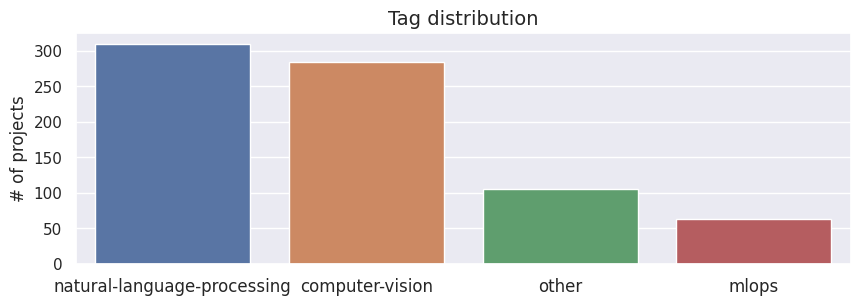

In [15]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

<details>
    <summary>We do have some data imbalance</summary>
but it's not too bad. If we did want to account for this, there are many strategies, including over-sampling less frequent classes and under-sampling popular classes, class weights in the loss function, etc.
</details>

### Wordcloud

<details>
    <summary>Is there enough signal in the title and description that's unique to each tag?</summary>
This is important to know because we want to verify our initial hypothesis that the project's title and description are high quality features for predicting the tag. And to visualize this, we're going to use a wordcloud. We also use a jupyter widget, which you can view in the notebook, to interactively select a tag and see the wordcloud for that tag.
</details>

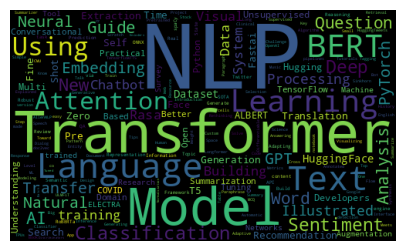

In [16]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


<details>
    <summary>There's a lot more exploratory data analysis that we can do</summary>
We can repeat this for the description text feature as well and see similar quality signals. This information will become useful when we decide how to use our features for modeling.
    but for now we've answered our questions around our class distributions and the quality of our text features.
</details>

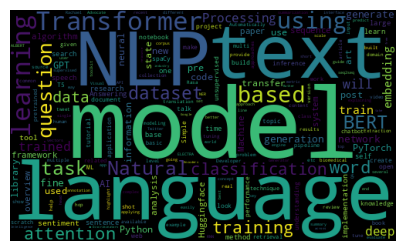

In [17]:
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.description.values
cloud = WordCloud(
            stopwords=STOPWORDS, background_color="black", collocations=False,
            width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

## Data Preprocessing

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

## Feature engineering

<details>
    <summary>combine existing input features to create new meaningful signal for helping the model learn.</summary>
    here's usually no simple way to know if certain feature combinations will help or not without empirically experimenting with the different combinations.
</details>

In [19]:
# Input
df['text'] = df.title + " " + df.description

### Cleaning

<details>
    <summary>text preprocessing operations</summary>
    Here, we'll be using Python's built-in regular expressions library re and the Natural Language Toolkit nltk.
</details>

In [20]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alphonse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [22]:
# Apply to text cleaning to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [23]:
# Dataframe cleanup
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


## Encoding

In [24]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [25]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [26]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [27]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

## Tokenizer

In [28]:
import numpy as np
from transformers import BertTokenizer

In [ ]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))